In [3]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram 

In [38]:

def initialize(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    U_init = qc.to_gate()
    U_init.name = "$U_i$"
    return U_init

def diffuser(n):
    qc = QuantumCircuit(n)
    qubits = range(n)
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(qubits)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(qubits)
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli (cx)
    qc.h(n-1)
    # Apply transformation |11..1> -> |00..0>
    qc.x(qubits)
    # Apply transformation |00..0> -> |s>
    qc.h(qubits)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)


def kakuro_oracle(qc, clause_qubits):
    # "(x0 != x1) and" 
    # "(x2 + 2 != x3) and" 
    # "(x3 != x4) and" 
    # "(x1 != x3) and"
    # "(x3 != x5) and"  
    # "(x5 != x6) and" 
    # "(x0 != x2) and" 
    # "(x1 != x5) and" 
    # "(x4 != x6) and" 
    # "(x3 == 2) and" 
    # "(x2 + x4 + x3 == 3)"

    # # rewritten with x3 == lsb of X3 and x4 == msb of X3
    # 3 constraints are explicit in the fact that x4, x1, and x5 are only one bit 
    # probably need to change the constraints a bit because they say explixitly not 
    # but will work with it for now 
    # "(x0 != x1) and" 
    # "(x2 != x3) and"   
    # "(x6 != x7) and" 
    # "(x0 != x2) and" 
    # "(x1 != x6) and" 
    # "(x5 != x7) and" 
    # "(x3 == 0) and"
    # "(x4 == 1) and" 
    # "(x2 + x5 + x3 + 2*x4 == 3)"
    # the last clause feels unnecessary 

    # "(x0 != x1) and" 
    # "(x6 != x7) and" 
    # "(x0 != x2) and" 
    # "(x1 != x6) and" 
    # "(x5 != x7) and"    
    xor_list = [[0, 1], [2, 3], [6, 7], [0, 2], [1, 6], [5, 7]]
    # Compute clauses
    i = 0
    for clause in xor_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # "(x3 == 0) and"
    qc.x(3)
    qc.cx(3, clause_qubits[i])
    qc.x(3)
    i+=1
    # "(x4 == 1) and"
    qc.cx(4, clause_qubits[i])
    i+=1
    # "(x2 + x5 + x3 + 2*x4 == 3)"

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in xor_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    
    # "(x3 == 0) and"
    qc.x(3)
    qc.cx(3, clause_qubits[i])
    qc.x(3)
    i+=1
    # "(x4 == 1) and"
    qc.cx(4, clause_qubits[i])
    i+=1

    qc.barrier()


n = 8
var_bits = QuantumRegister(n, name="x")
clause_qubits = QuantumRegister(n, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(n, name='cbits')
grover_circuit = QuantumCircuit(var_bits, clause_qubits, output_qubit, cbits)
grover_circuit.append(initialize(n), range(n))
# Initialize 'out0' in state |->
grover_circuit.initialize([1, -1]/np.sqrt(2), output_qubit)
grover_circuit.barrier()
for i in range(3):
    kakuro_oracle(grover_circuit, clause_qubits)
    grover_circuit.append(diffuser(n), range(n))
grover_circuit.measure(var_bits, cbits)
# grover_circuit.draw(output='mpl', filename='circuit.png', scale=0.3)

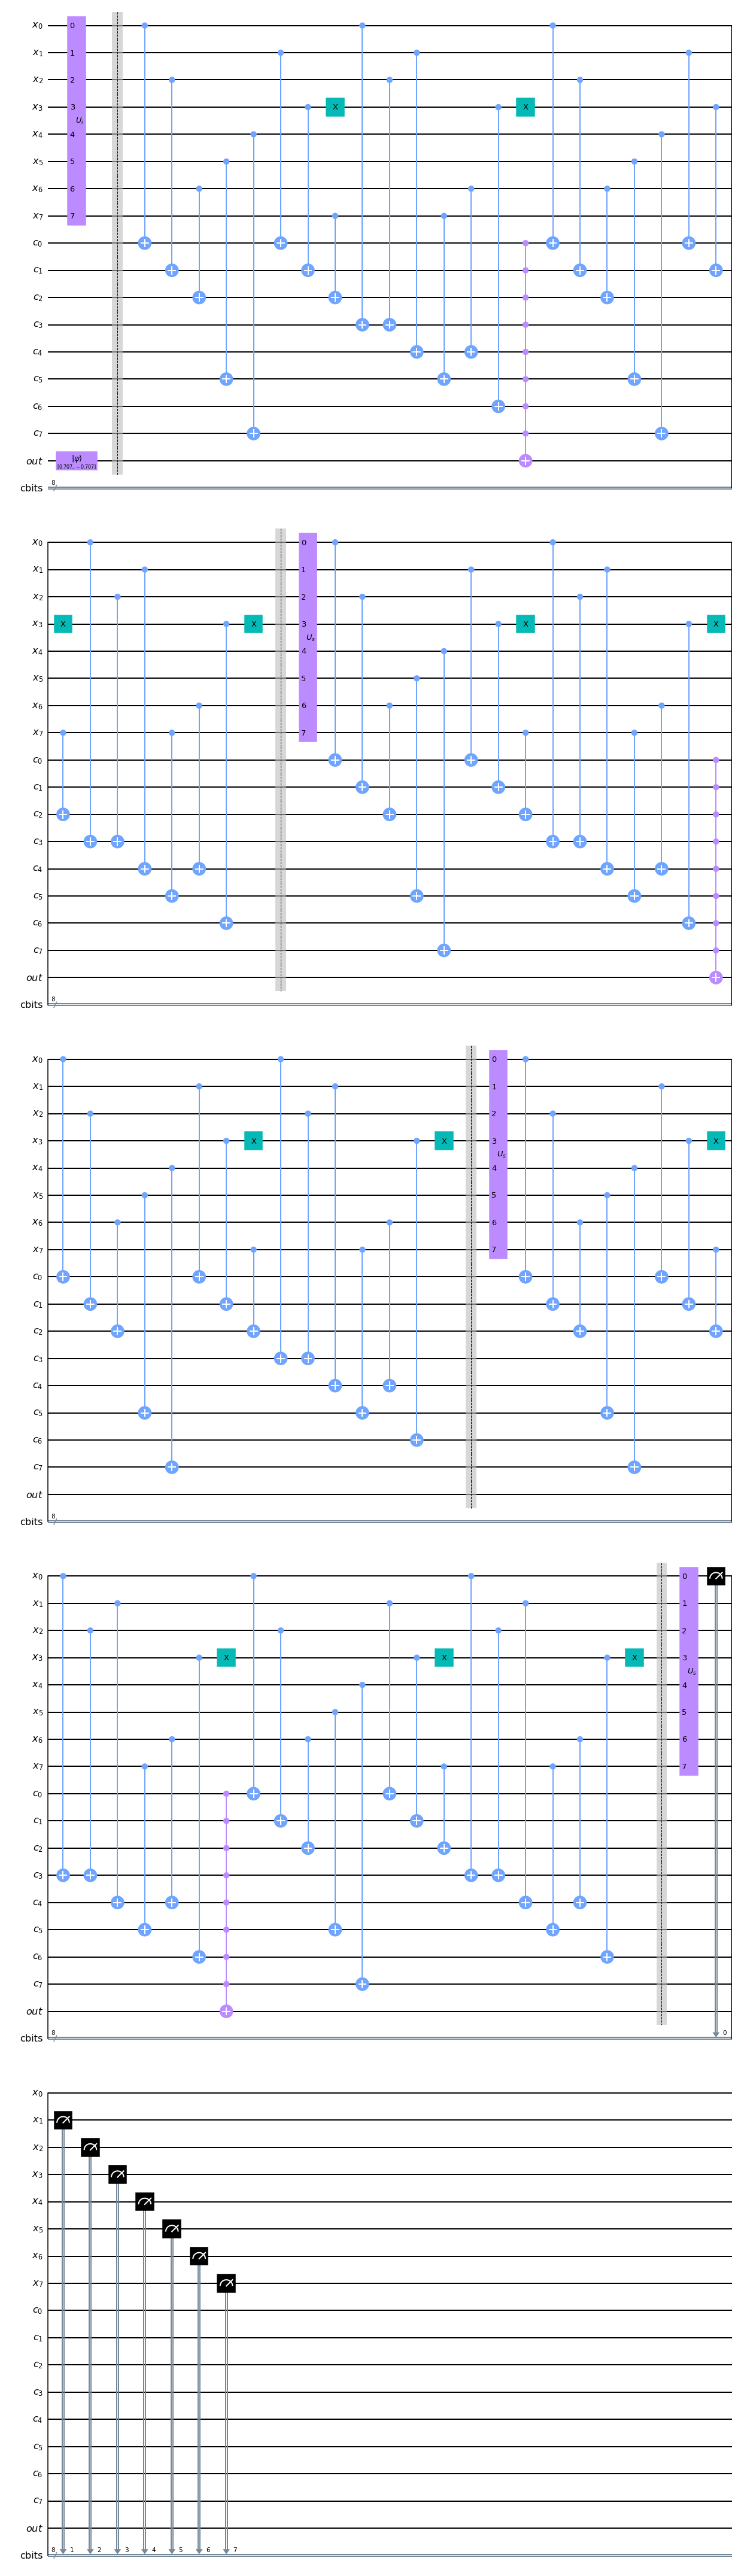

In [44]:
grover_circuit.draw(output='mpl', filename='circuit.png')

In [41]:
grover_circuit.draw()

┌────────┐            ░                                    »
    x_0: ───────────┤0       ├────────────░───■────────────────────────────────»
                    │        │            ░   │                                »
    x_1: ───────────┤1       ├────────────░───┼────────────────────────■───────»
                    │        │            ░   │                        │       »
    x_2: ───────────┤2       ├────────────░───┼────■───────────────────┼───────»
                    │        │            ░   │    │                   │       »
    x_3: ───────────┤3       ├────────────░───┼────┼───────────────────┼────■──»
                    │  $U_i$ │            ░   │    │                   │    │  »
    x_4: ───────────┤4       ├────────────░───┼────┼──────────────■────┼────┼──»
                    │        │            ░   │    │              │    │    │  »
    x_5: ───────────┤5       ├────────────░───┼────┼─────────■────┼────┼────┼──»
                    │        │            ░   │    │         │    │    │    │  »
    x_6: ───────────┤6       ├────────────░───┼────┼────■────┼────┼────┼────┼──»
                    │        │            ░   │    │    │    │    │    │    │  »
    x_7: ───────────┤7       ├────────────░───┼────┼────┼────┼────┼────┼────┼──»
                    └────────┘            ░ ┌─┴─┐  │    │    │    │  ┌─┴─┐  │  »
    c_0: ─────────────────────────────────░─┤ X ├──┼────┼────┼────┼──┤ X ├──┼──»
                                          ░ └───┘┌─┴─┐  │    │    │  └───┘┌─┴─┐»
    c_1: ─────────────────────────────────░──────┤ X ├──┼────┼────┼───────┤ X ├»
                                          ░      └───┘┌─┴─┐  │    │       └───┘»
    c_2: ─────────────────────────────────░───────────┤ X ├──┼────┼────────────»
                                          ░           └───┘  │    │            »
    c_3: ─────────────────────────────────░──────────────────┼────┼────────────»
                                          ░                  │    │            »
    c_4: ─────────────────────────────────░──────────────────┼────┼────────────»
                                          ░                ┌─┴─┐  │            »
    c_5: ─────────────────────────────────░────────────────┤ X ├──┼────────────»
                                          ░                └───┘  │            »
    c_6: ─────────────────────────────────░───────────────────────┼────────────»
                                          ░                     ┌─┴─┐          »
    c_7: ─────────────────────────────────░─────────────────────┤ X ├──────────»
         ┌──────────────────────────────┐ ░                     └───┘          »
    out: ┤ Initialize(0.70711,-0.70711) ├─░────────────────────────────────────»
         └──────────────────────────────┘ ░                                    »
cbits: 8/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                          »
«    x_0: ───────■──────────────────────────────────■──────────────────────»
«                │                                  │                      »
«    x_1: ───────┼─────────■────────────────────────┼──────────────────────»
«                │         │                        │                      »
«    x_2: ───────┼────■────┼────────────────────────┼────■─────────────────»
«         ┌───┐  │    │    │                 ┌───┐  │    │                 »
«    x_3: ┤ X ├──┼────┼────┼──────────────■──┤ X ├──┼────┼─────────────────»
«         └───┘  │    │    │              │  └───┘  │    │                 »
«    x_4: ───────┼────┼────┼──────────────┼─────────┼────┼──────────────■──»
«                │    │    │              │         │    │              │  »
«    x_5: ───────┼────┼────┼──────────────┼─────────┼────┼─────────■────┼──»
«                │    │    │              │         │    │         │    │  »
«    x_6: ───────┼────

In [42]:

aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(grover_circuit, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
print(result.get_counts())

{'10001100': 2, '00011000': 4, '11001100': 4, '00101101': 1, '00110011': 3, '00000100': 5, '01110111': 8, '01001011': 2, '11101010': 6, '11000011': 4, '11111100': 5, '01100011': 6, '10010110': 190, '11111011': 4, '01000000': 2, '01111110': 2, '01011110': 3, '10110000': 3, '01000100': 5, '01111010': 5, '11001110': 3, '11100111': 3, '00101011': 3, '00110101': 4, '11110011': 5, '01101100': 3, '11110010': 3, '01110001': 1, '01001101': 3, '11000101': 6, '10000011': 2, '11110111': 4, '10110010': 2, '10000000': 3, '01010001': 2, '10111101': 4, '00101110': 4, '00110010': 3, '01111111': 2, '01000011': 3, '01011011': 4, '10110111': 5, '10110100': 4, '01011010': 4, '11100100': 1, '11001111': 4, '00110110': 3, '00101010': 6, '10110011': 1, '01011111': 5, '10001110': 3, '01010010': 5, '01010011': 4, '10111111': 3, '11111110': 3, '10110101': 2, '10000111': 3, '01100000': 10, '01111001': 4, '10010001': 6, '10101111': 3, '11001000': 5, '11101101': 5, '11000110': 6, '11010111': 4, '01100001': 2, '10010

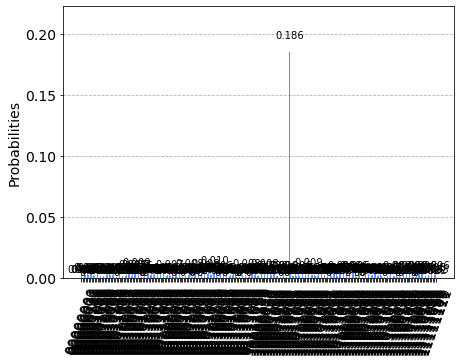

In [43]:
plot_histogram(result.get_counts())